<a href="https://colab.research.google.com/github/BingHung/AI/blob/master/Helix_NN_(BPN)_20210704.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

''' ################################################### 
    # Pure AI (Neural Network model building)
      BingHung  - 20190716                      
      [sklearn.neural_network.MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)        
 ################################################### '''

In [35]:
# 載入套件
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # 畫圖套件
from sklearn.neural_network import MLPRegressor

In [36]:
# Upload CSV From a local drive
from google.colab import files
uploaded = files.upload()

In [37]:
''' ################################################### 
# STEP 1    Define dataPath and read CSV
         Split the data into x and y
################################################### '''

# 設定資料路徑
global PARASWITCH
PARASWITCH = 7

if (PARASWITCH == 4):
    # Re,Pr
    df = pd.read_csv('Helix_NN_20190717_4para.csv')
    # 將資料分為 解釋變數X 與 反應變數Y
    x = np.array(df[['k_d', 'Re', 'Pr', 'angle']])
    
else:    
    #Helix velocity, density
    df = pd.read_csv('Helix_NN_20190716_7para.csv')
    # 將資料分為 解釋變數X 與 反應變數Y
    x = np.array(df[['den', 've', 'k', 'vis', 'sp', 'd', 'angle']])
    
xmax = np.amax(x, axis=0)
x = x/xmax 

y = df['h'].values
ymax = np.amax(y, axis=0)
y =y/ymax

In [38]:
''' ########################################################################## 
# STEP 2    The amount of data  = 20, which is small
         For model validation,  leave-one-out (LOOCV) would be recommended 
         Prepare for leave-one-out (LOOCV)                         
############################################################################# '''
# 準備 K-fold 抓取訓練/測試資料的 index
nfold = x.shape[0] # leave-one-out
# 複製好幾個 [0 1 2] index 序列，抓前 x.shape[0] 個就夠了
folds_ordered = np.tile(np.arange(nfold), x.shape[0])[:x.shape[0]]
# 隨機打亂 [0 1 2] index 序列
# 設定 random seed (驗證結果再現性)
np.random.seed(1)
folds = np.random.permutation(folds_ordered)
# 預留空間存放各模型的預測值
kfold_ytest_2 = np.zeros_like(y) # 網路

In [39]:
''' ################################################### 
# STEP 3    Define the scale of h value                
################################################### '''
scale = ymax #8695.88

In [40]:
''' ####################################################################
# STEP 4    Execute leave-one-out (LOOCV) - K-fold Cross Validation               
#################################################################### '''
# 執行 K-fold Cross Validation
for i in range(nfold):
  # 取第 i 次 K-fold 的訓練資料
  x_train = x[(folds != i),:].copy()
  y_train = y[folds != i].copy()
  # 取第 i 次 K-fold 的測試資料
  x_test  = x[(folds == i),:].copy()
  y_test = y[folds == i].copy()

  ''' ####################################################################
    # STEP 5    Define NN-Model, Train the model and Predict the h(from AI)              
    #################################################################### '''
  # 用訓練資料 _train 建網路模型
  ann2 = MLPRegressor(hidden_layer_sizes=(5,4), activation ='tanh', solver = 'lbfgs', max_iter = 10000)
  # 用預測資料 x_test 以網路模型 預測 Y -> y_test 
  ann2.fit(x_train, y_train)
  # 將預測值 y_test 儲存回 kfold_ytest_2 中相對應的位置
  y_ann2 = ann2.predict(x_test)
  kfold_ytest_2[folds == i] = y_ann2 

In [41]:
# K-fold 完成
# 計算 CV 誤差 (RMSE)
''' #########################
# STEP 6   Calculate RMSE             
############################ '''
kfold_rmse_2 = np.sqrt(np.mean((y * scale - kfold_ytest_2 * scale)**2))
print('NN LOOCV RMSE: ' + str(kfold_rmse_2))

#調整h比例
y_p = kfold_ytest_2 * scale
y_a = y * scale

NN LOOCV RMSE: 1112.1762464028013


Text(0, 0.5, 'h (NN-LOOCV)')

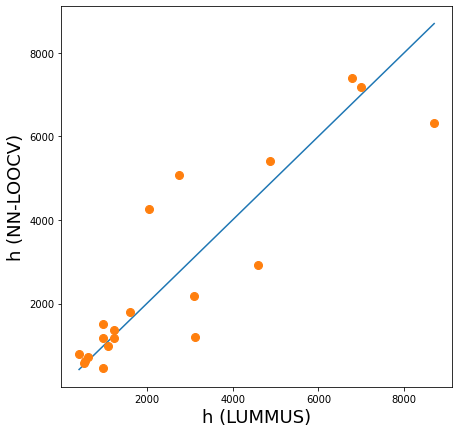

In [42]:
''' ################################################################
# STEP 7 Model Prediction Validation - leave-one-out (LOOCV)                        
################################################################ '''


#繪圖
figLim = [np.array(min(np.min(y_a), np.min(y_p))),
          np.array(max(np.max(y_a), np.max(y_p)))]
fig = plt.figure(figsize = (7,7))
ax = plt.subplot(1,1,1)
ax.plot(np.array(figLim), np.array(figLim))
ax.plot(y_a, y_p, '.', markersize = 16)
ax.set_xlabel('h (LUMMUS)', fontsize = 18)
ax.set_ylabel('h (NN-LOOCV)', fontsize = 18)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


NN Fitted RMSE: 323.1703028479184


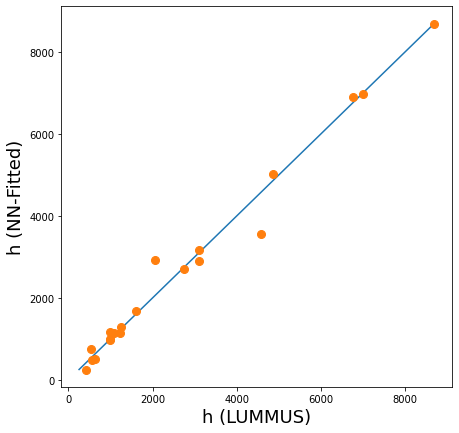

In [43]:
''' ################################################
    # STEP 8  Model Prediction  - Fitted (All In)                        
    ################################################ '''

annf = MLPRegressor(hidden_layer_sizes = (5,4), 
                    activation ='tanh', 
                    solver = 'lbfgs')
annf.fit(x, y)
y_annf = annf.predict(x)
  
rmse_f = np.sqrt(np.mean((y * scale - y_annf * scale)**2))
print('NN Fitted RMSE: ' + str(rmse_f))

y_p_f = y_annf * scale

#繪圖
figLim = [np.array(min(np.min(y_a), np.min(y_p_f))),
          np.array(max(np.max(y_a), np.max(y_p_f)))]
fig = plt.figure(figsize = (7,7))
ax = plt.subplot(1,1,1)
ax.plot(np.array(figLim), np.array(figLim))
ax.plot(y_a, y_p_f, '.', markersize = 16)
ax.set_xlabel('h (LUMMUS)', fontsize = 18)
ax.set_ylabel('h (NN-Fitted)', fontsize = 18)
#
nn_result = pd.DataFrame(np.array([y_a, y_p, y_p_f]).transpose(), 
                          columns = ['h (LUMMUS)', 'h (NN-LOOCV)', 'h (NN-Fitted)'])

In [44]:
nn_result

,h (LUMMUS),h (NN-LOOCV),h (NN-Fitted)
0,7001.73,7187.448757,6967.937851
1,6776.87,7382.457910,6899.836075
2,8695.88,6319.411196,8698.942667
3,990.20,1511.348779,1174.471643
4,541.68,587.026736,757.813837
5,421.42,797.138277,253.781896
6,555.12,616.257326,493.415457
7,986.64,1172.363599,992.852696
8,628.58,728.835679,513.808518
9,1086.32,977.942849,1155.399770
